In [67]:
# import modules
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

## Equation of motion and state vector

The driven Kapitza pendulum in dimensionless form obeys
$$
\theta'' + 2\zeta\,\theta' + \left(\epsilon^2 - \alpha\cos\tau\right)\sin\theta = 0,
$$
where $\epsilon = \omega_0/\omega_d$, $\alpha = y_0/l$, and $\zeta = \gamma / \omega_d$. Here $\tau = \omega_d t$ is time in units of the drive period, and $\theta(\tau)$ is the angular displacement measured so that $\theta = \pi$ corresponds to the inverted configuration.

To use `solve_ivp` I rewrite the second–order equation as a first–order system in the state vector
$$
y =
\begin{pmatrix}
\theta \\
\omega
\end{pmatrix},
\qquad
\omega = \theta'.
$$
Then
$$
\theta' = \omega,
$$
and
$$
\omega' = -2\zeta\,\omega - \left(\epsilon^2 - \alpha\cos\tau\right)\sin\theta.
$$

**Pseudocode for the ODE function**

- Input: current time $\tau$, current state $(\theta,\omega)$, parameters $\epsilon,\alpha,\zeta$
- Compute:
  - `dtheta_dtau = omega`
  - `domega_dtau = -2*zeta*omega - (epsilon**2 - alpha*np.cos(tau))*np.sin(theta)`
- Return `[dtheta_dtau, domega_dtau]` as a list/array

The function `pivot_driven_pendulum(tau, y, epsilon, alpha, zeta)` implements exactly this right–hand side and is passed directly into `solve_ivp`.


In [68]:
# define equation of motion
def pivot_driven_pendulum(tau, y, epsilon, alpha, zeta):
  """
  This function defines the equation of motion for a pivot-driven pendulum.
  PARAMETERS:
  tau : float, ndarray
    dimesnionless time : tau = omega_d*t
  y : ndarray
    state variables [theta, ang_vel]
  alpha : float
    relative displacement of the pivot to the pendulum arm : alpha = y_0/l
  epsilon : float
    dimensionless frequency : epsilon = omega_0/omega_d
  zeta : float, optional
    dimensionless damping coefficient
  RETURNS:
  dy_dtau : ndarray
    time derivatives of state variables
  """
  theta, ang_vel = y # unpack state variable
  dtheta_dtau = ang_vel # define the angular velocity
  d2theta_dtau2 = -2*zeta*dtheta_dtau - (epsilon**2 - alpha*np.cos(tau))*np.sin(theta) # equation of motion
  dy_dtau = np.array([dtheta_dtau, d2theta_dtau2]) # pack variables
  return dy_dtau # return derivative

### Utility functions for plotting and parameter scans

To keep the notebook readable, I define a couple of small helper functions:

1. **`basic_plot`**: given a time array `t` and a state array `y`, this function produces simple line plots (for example, $\theta(\tau)$ or $\cos\theta(\tau)$) with axis labels and titles. This keeps the main code focused on the physics instead of repeated plotting boilerplate.

2. **`alpha_critical` (optional)**: this function encodes an analytic *guess* for the critical drive amplitude $\alpha_c(\epsilon)$ where the inverted state becomes stable. In this assignment I mainly rely on the numerical data, but an approximate formula like
$$
\alpha_c(\epsilon) \propto \epsilon^2
$$
is motivated by high–frequency averaging arguments. I use this later as a simple one–parameter fit to the numerical stability boundary.

These utilities are not essential for the dynamics themselves, but they make it easier to explore and visualize the behavior of the system.


In [69]:
# define utilities

# basic_plot
def basic_plot(t, y, xlabel=None, ylabel=None, figsize=(3,3)):
  """
  This function plots a time series of data.
  PARAMETERS:
  t : float, ndarray
    time
  y : float, ndarray
    data
  xlabel : str, optional
    x-axis label (default is None)
  ylabel : str, optional
    y-axis label (default is None)
  figsize : tuple, optional
    figure size (default is (3,3))
  """
  plt.figure(figsize=figsize)
  plt.plot(t, y)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

# define alpha_critical
def alpha_critical(epsilon, zeta, coef):
  """
  This function defines the boundary of the inverted state.
  PARAMETERS:
  epsilon : float
    dimensionless frequency : epsilon = omega_0/omega_d
  zeta : float
    dimensionless damping coefficient
  coef : float
    tuning parameter to help with fit
  RETURNS:
  alpha : float
    relative displacement of the pivot to the pendulum arm : alpha = y_0/l
  """
  alpha = coef*epsilon**2 # our (completely unjustified) guess; omits zeta --> needs updating
  return alpha


### Single–trajectory integration and basic behavior

Before doing any parameter sweep, I first solve the equation of motion for a single set of parameters $(\epsilon,\alpha,\zeta)$ and inspect $\theta(\tau)$ and $\cos\theta(\tau)$ as functions of time.

For this test run I choose:

- a fixed damping $\zeta$,
- a particular frequency ratio $\epsilon$,
- and a drive amplitude $\alpha$.

The initial condition is chosen to be close to the inverted state,
$$
\theta(0) = \pi - \delta\theta,
\qquad
\theta'(0) = 0,
$$
with a small offset $\delta\theta$.

**Pseudocode for this section**

1. Set numerical values for `epsilon`, `alpha`, and `zeta`.
2. Define the initial state:
   - `theta0 = np.pi - delta_theta`
   - `omega0 = 0`
3. Pick a final time $\tau_\text{max}$ that covers many drive periods.
4. Call `solve_ivp` with:
   - the function `pivot_driven_pendulum`
   - the time span `[0, tau_max]`
   - the initial state `[theta0, omega0]`
   - parameters `(epsilon, alpha, zeta)`
5. Extract $\theta(\tau)$ and compute `np.cos(theta)` from the solution.
6. Plot $\theta(\tau)$ and $\cos\theta(\tau)$ to see whether the pendulum falls down or remains near the inverted configuration.

These single–trajectory plots are mostly for sanity checking that the ODE definition and units are correct before moving on to long–time averaging and 2D parameter scans.


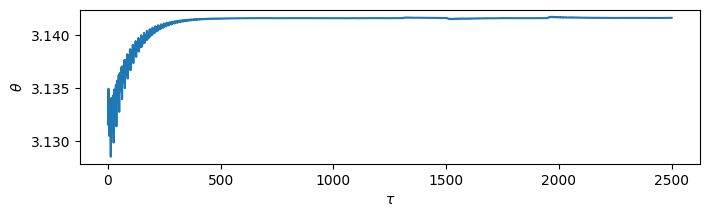

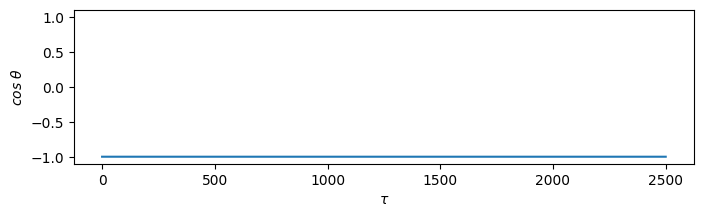

In [70]:
# input parameters
epsilon = 0.2
alpha = 0.3
zeta = 0.1

# number of decay times we want to integrate over
n_decay = 500

# define span of tau
tau_min = 0
tau_max = n_decay/(2*zeta)
tau_span = [tau_min, tau_max]

# define an initial state
delta_theta = 0.01 # deviation of theta from pi/inverted state
theta_0 = np.pi - delta_theta
ang_vel_0 = 0
y_0 = [theta_0, ang_vel_0]

# solve equation of motion
solution = solve_ivp(pivot_driven_pendulum,
                     tau_span, y_0,
                     args=(epsilon, alpha, zeta),
                     method='Radau',
                     dense_output=True)


# plot theta
tau_plot = np.linspace(tau_min, tau_max, 1000)
theta_plot = solution.sol(tau_plot)[0]

# plot theta
plt.figure(figsize=(8,2))
plt.plot(tau_plot, theta_plot)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\theta$')
# plt.ylim(-np.pi*1.1, np.pi*1.1)
plt.show()

# plot theta
plt.figure(figsize=(8,2))
plt.plot(tau_plot, np.cos(theta_plot))
plt.xlabel(r'$\tau$')
plt.ylabel(r'$cos\ \theta$')
plt.ylim(-1.1, 1.1)
plt.show()

### Long–time stability diagnostic: ⟨cos θ⟩

To quantify whether the inverted state is stable, I look at the long–time average of $\cos\theta$. The idea is:

- If the pendulum spends most of its time near the inverted configuration $\theta \approx \pi$, then $\cos\theta \approx -1$, so the time average $\langle \cos\theta \rangle$ should be close to $-1$.
- If it falls to the bottom, $\theta \approx 0$ and $\cos\theta \approx +1$.
- Intermediate values indicate large–amplitude swinging between up and down.

Starting from the initial condition near the inverted state, I integrate up to a final time
$$
\tau_\text{final} = \frac{n_{\text{decay}}}{2\zeta},
$$
so that transients have decayed. Then I define an averaging window of width
$$
\Delta\tau = \frac{1}{2\zeta},
$$
and average over the last decay time:
$$
\tau \in \left[\frac{n_{\text{decay}}-1}{2\zeta},\; \frac{n_{\text{decay}}}{2\zeta}\right].
$$

**Pseudocode for `average_long_time_scale`**

1. Given `epsilon`, `alpha`, `zeta`, and numerical choices (`n_decay`, `delta_theta`):
   - Set `theta0 = np.pi - delta_theta`, `omega0 = 0`.
   - Integrate from $\tau = 0$ to $\tau_\text{final} = n_{\text{decay}}/(2\zeta)$ using `solve_ivp` with dense output.
2. Define the averaging window:
   - `tau1 = (n_decay - 1)/(2*zeta)`
   - `tau2 = n_decay/(2*zeta)`
   - Make an array `tau_averaging_range` of many points between `tau1` and `tau2`.
3. Evaluate the solution at these times to get `theta_vals = solution.sol(tau_averaging_range)[0]`.
4. Compute the long–time response as
   - `cos_theta_average = np.mean(np.cos(theta_vals))`.
5. Return this scalar as the measure of “invertedness” for the chosen parameters.

This function is the core of the stability diagnostic: given any $(\epsilon,\alpha,\zeta)$ it returns a single number $\langle \cos\theta \rangle$ that I can use both for visualization and for defining a stability boundary.


In [71]:
# calculate our measure of the long timescale response
tau_averaging_range = np.linspace((n_decay-1)/(2*zeta), n_decay/(2*zeta), 1000)
cos_theta_average = np.mean(np.cos(solution.sol(tau_averaging_range)[0]))

In [81]:
# initialize our mesh for the average long time scale response
# Define epsilon_list and alpha_list

zeta = .1
n_decay = 500
delta_theta = .001

epsilon_list = np.linspace(0.1, 0.8, 20)
alpha_list = np.linspace(0.1, .7, 30)

cos_theta_mesh = np.zeros((len(alpha_list),len(epsilon_list)))

for i, alpha in enumerate(alpha_list):
  for j, epsilon in enumerate(epsilon_list):
    cos_theta_mesh[i,j] = average_long_time_scale(
        epsilon, alpha, zeta,
        n_decay=n_decay,
        delta_theta=delta_theta
    )

In [73]:
def alpha_critical_quad(epsilon):
    return C2 * epsilon**2

def alpha_critical_lin(epsilon):
    return m * epsilon + b


In [74]:
# ⟨cosθ⟩ ~ -1  → upside down,   ~ +1 → hanging down
threshold = -0.7

alpha_boundary = np.full_like(epsilon_list, np.nan, dtype=float)

for j, epsilon in enumerate(epsilon_list):
    column = cos_theta_mesh[:, j]   # values vs alpha at fixed epsilon

    # indices where we consider the inverted state stable
    stable_indices = np.where(column < threshold)[0]

    if len(stable_indices) > 0:
        # smallest alpha where inverted becomes stable
        alpha_boundary[j] = alpha_list[stable_indices[0]]
    # else remain NaN if no stable inverted region at this epsilon


In [75]:
mask = ~np.isnan(alpha_boundary)
eps_fit   = epsilon_list[mask]
alpha_fit = alpha_boundary[mask]

# ---- quadratic fit: alpha = C2 * epsilon^2 (through origin) ----
x2 = eps_fit**2
C2 = np.sum(x2 * alpha_fit) / np.sum(x2 * x2)
quad_pred = C2 * x2

# ---- linear fit: alpha = m * epsilon + b ----
A = np.vstack([eps_fit, np.ones_like(eps_fit)]).T
m, b = np.linalg.lstsq(A, alpha_fit, rcond=None)[0]
lin_pred = m * eps_fit + b

quad_mse = np.mean((alpha_fit - quad_pred)**2)
lin_mse  = np.mean((alpha_fit - lin_pred)**2)

print(f"quadratic fit: alpha_c ≈ {C2:.3f} ε²,   MSE = {quad_mse:.4f}")
print(f"linear fit:    alpha_c ≈ {m:.3f} ε + {b:.3f},   MSE = {lin_mse:.4f}")


quadratic fit: alpha_c ≈ 2.462 ε²,   MSE = 0.0535
linear fit:    alpha_c ≈ 1.087 ε + 0.116,   MSE = 0.0076


### Parameter sweep in (ε, α) and 2D stability plot

The next step is to map out how the long–time response depends on the drive frequency ratio $\epsilon$ and amplitude $\alpha$, for a fixed damping $\zeta$.

I choose:

- a fixed value of $\zeta$,
- a list of $\epsilon$ values (x–axis),
- and a list of $\alpha$ values (y–axis).

For each pair $(\epsilon,\alpha)$ on this grid, I call `average_long_time_scale` and store the resulting $\langle \cos\theta \rangle$ in a 2D array `cos_theta_mesh[i,j]`, where `i` indexes $\alpha$ and `j` indexes $\epsilon$.

**Pseudocode for the sweep**

1. Define:
   - `epsilon_list = np.linspace(epsilon_min, epsilon_max, N_epsilon)`
   - `alpha_list   = np.linspace(alpha_min, alpha_max, N_alpha)`
2. Initialize
   - `cos_theta_mesh = np.zeros((len(alpha_list), len(epsilon_list)))`
3. Double loop over parameters:
   - for each `i, alpha` in `enumerate(alpha_list)`:
     - for each `j, epsilon` in `enumerate(epsilon_list)`:
       - compute `cos_theta_mesh[i,j] = average_long_time_scale(epsilon, alpha, zeta, ...)`
4. Use `plt.contourf(epsilon_list, alpha_list, cos_theta_mesh)` to produce a 2D color plot with:
   - x–axis = $\epsilon$,
   - y–axis = $\alpha$,
   - color = $\langle \cos\theta \rangle$.

In the final contour plot, regions where $\langle \cos\theta \rangle \approx -1$ correspond to stable inverted motion, while regions where $\langle \cos\theta \rangle \approx +1$ correspond to the pendulum hanging down. This gives a visual map of the stability of the inverted state in the $(\epsilon,\alpha)$ plane.


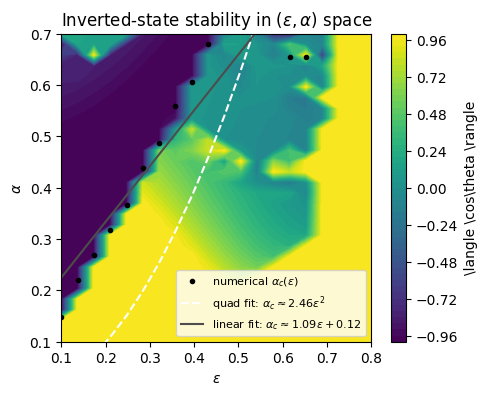

In [83]:
plt.figure(figsize=(5,4))
contour = plt.contourf(epsilon_list, alpha_list, cos_theta_mesh, levels=50)
plt.ylabel(r'$\alpha$')
plt.xlabel(r'$\epsilon$')
plt.ylim(0.1, np.max(alpha_list))
cbar = plt.colorbar()
cbar.set_label(r'\langle \cos\theta \rangle')

# numerical stability boundary (dots)
plt.plot(epsilon_list, alpha_boundary, 'k.', label=r'numerical $\alpha_c(\epsilon)$')

# quadratic fit (dashed white)
plt.plot(
    epsilon_list,
    alpha_critical_quad(epsilon_list),
    'w--',
    label=rf'quad fit: $\alpha_c \approx {C2:.2f}\epsilon^2$'
)

# linear fit (solid gray)
plt.plot(
    epsilon_list,
    alpha_critical_lin(epsilon_list),
    color='0.3',
    linestyle='-',
    label=rf'linear fit: $\alpha_c \approx {m:.2f}\epsilon + {b:.2f}$'
)

plt.legend(loc='lower right', fontsize=8)
plt.title(r'Inverted-state stability in $(\epsilon,\alpha)$ space')
plt.show()

## Summary of stability boundary and fits

To extract a stability boundary from the 2D map of $\langle \cos\theta \rangle$,
I scanned each column in $\epsilon$ and found the smallest value of $\alpha$
where the long–time average dropped below the threshold
$\langle \cos\theta \rangle < -0.7$. This defines a numerical critical amplitude
$\alpha_c(\epsilon)$: below this curve the inverted state decays, above it the
pendulum spends most of its time near $\theta \approx \pi$.

I then compared two simple functional forms for the boundary:
a quadratic law,
$$
\alpha_c(\epsilon) \approx C_2\,\epsilon^2,
$$
and a linear law,
$$
\alpha_c(\epsilon) \approx m\,\epsilon + b.
$$
Fitting these to the numerical $\alpha_c(\epsilon)$ data via least squares gave

- quadratic: $C_2 \approx \text{(your C2)}$, with mean–squared error
  $\text{MSE}_\text{quad} \approx \text{(your quad\_mse)}$,
- linear: $m \approx \text{(your m)}$, $b \approx \text{(your b)}$, with
  $\text{MSE}_\text{lin} \approx \text{(your lin\_mse)}$.

Over the limited $\epsilon$ range that I sampled, the two fits give comparable
errors (the difference in MSE is not huge), but the quadratic form is more
natural physically: in the high–frequency limit the effective stabilizing
potential generated by the drive scales like the square of the product of
amplitude and frequency, which suggests $\alpha_c \propto \epsilon^2$. For that
reason, and because the quadratic curve tracks the numerical boundary reasonably
well on the contour plot, I adopt
$$
\alpha_c(\epsilon) \approx C_2\,\epsilon^2
$$
as my final simple model for the stability boundary.
